In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mineralML as mm
#import Thermobar as pt


In [ ]:
#mm.__version__

In [6]:
def process_excel_file(file_path, sheet_name=1):
    # Load the Excel file from the specified sheet without headers
    data = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
    
    # Find indices where 'Element' is found in column 0 to determine the start of data blocks
    data_blocks_indices = data.index[data[0] == 'Element'].tolist()
    
    # Initialize an empty DataFrame to store processed data
    processed_data = []

    # Iterate through each data block
    for i, start in enumerate(data_blocks_indices):
        print(f"Processing row: {start + 1}")
        # The label for the block is in the row just before the 'Element' row
        label = data.iloc[start - 1, 0]
        
        # Identify the end of the block by finding the next 'Total' row after 'Element'
        total_index = data.index[(data[0] == 'Total') & (data.index > start)].min()
        end = total_index  # Set end to the row before 'Total
        
        # Extract data block for current sample
        block = data.iloc[start + 1:end]  # Extract rows between 'Element' and 'Total'
        headers = ['Element'] + data.iloc[start, 1:].dropna().values.tolist()  # Get headers from the 'Element' row
        
        # Ensure the number of columns matches expected headers
        block.columns = headers[:block.shape[1]]
        
        # Prepare a row dictionary to append to the DataFrame
        row_dict = {'Sample Name': label}
        for _, row in block.iterrows():
            element = row['Element']
            
            for col in row.index[1:]:  # Skip the 'Element' column for key names
                if pd.notna(row[col]):  # Check for NaN
                    col_name = f"{col}_{element}"  # Use header from 'Element' row for column names
                    row_dict[col_name] = row[col]

        # Capture 'Total_wt%' and 'Total_Oxide %' from the 'Total' row
        total_row = data.iloc[total_index, :]  # Correctly access the 'Total' row
        row_dict['Total_wt%'] = total_row.get(headers.index('Wt%'), None)  # Use dynamic index for 'Wt%'
        row_dict['Total_Oxide%'] = total_row.get(headers.index('Oxide %'), None)  # Use dynamic index for 'Oxide %'
        # row_dict['Cation_Sum'] = total_row.get(headers.index('Number of Ions'), None)  # Use dynamic index for 'Oxide %'
        # row_dict['Cation_Sum']=row_dict['Cation_Sum'].replace('(Cation sum)', '')

                    
        processed_data.append(row_dict)

    return pd.DataFrame(processed_data)



In [7]:
def sort_columns(df, norm = False):
    # Start with fixed priority columns
    priority_cols = ['Sample Name', 'Total_wt%', 'Total_Oxide%'] #, 'Cation_Sum']

    # Define exact matches for metrics and their intended order
    col_order = ['Oxide %_', 'Oxide % Sigma_', 'norm_Oxide %_', 'Wt%_', 'Wt% Sigma_']


    element_to_oxide = {
        'Si': 'SiO2', 'Ti': 'TiO2', 'Al': 'Al2O3', 'Ca': 'CaO',
        'Cr': 'Cr2O3', 'Fe': 'FeO', 'Ni': 'NiO', 'Na': 'Na2O',
        'Mg': 'MgO','Mn': 'MnO',
        'K': 'K2O', 'P': 'P2O5'
    }

    # Rename columns based on the mapping
    new_columns = {}
    for col in df.columns:
        if 'Oxide' in col:
            for element, oxide in element_to_oxide.items():
                if f'_{element}' in col:
                    new_col_name = col.replace(f'_{element}', f'_{oxide}')
                    new_columns[col] = new_col_name

    df.rename(columns=new_columns, inplace=True)
    
    
    # Find the columns that are going to be involved in the normalization
    desired_string = 'Oxide %_'
    matching_columns = [col for col in df.columns if desired_string in col]
    matching_column_indices = [df.columns.get_loc(col) for col in matching_columns]
        
    # Convert SO3 to SO2
    if 'Oxide %_S' in list(df.keys()):
        df = df.rename(columns={'Oxide %_S': 'Oxide %_SO2'})
        df['Oxide %_SO2'] = df['Oxide %_SO2']*(32.065+2*15.999)/(32.065+3*15.999)

    # normalization
    df_norm = df.iloc[:, matching_column_indices]
    df_norm = df_norm.map(lambda x: 0 if x < 0 else x)
    sum = df_norm.sum(axis = 1)
    df_norm = 100*df_norm.div(sum, axis = 0)

    df_norm = df_norm.add_suffix('_norm')
    df_norm = df_norm.add_prefix('norm_')
    df_norm = df_norm.fillna(0.0)

    df = pd.concat([df, df_norm], axis=1)

    # if norm is true, switch normalized and un-normalized analyses
    if norm is True:
        elements = set([col.split('_')[-1].split('_norm')[0] for col in df.columns if 'Oxide %_' in col])
        
        # Swap the data between corresponding columns
        for element in elements:
            if element != 'norm':
                oxide_col = f'Oxide %_{element}'
                norm_oxide_col = f'norm_Oxide %_{element}_norm'
                
                # Swap the data using a temporary variable
                temp = df[oxide_col].copy()
                df[oxide_col] = df[norm_oxide_col]
                df[norm_oxide_col] = temp


    # Collect and sort metric-specific columns using more accurate matching
    metric_cols = []
    for metric in col_order:
        # This loop will check if the columns end with the metric name preceded by an underscore
        # to ensure we match 'Oxide %_Mg' but not 'Something Oxide %_Mg'
        metric_cols.extend(sorted([col for col in df.columns if col.startswith(metric)]))

    
    # Collect all other columns not in priority or metric-specific lists
    other_cols = [col for col in df.columns if col not in priority_cols and col not in metric_cols]

    # Move 'Apparent Concentration' columns to the end
    apparent_concentration_cols = [col for col in other_cols if 'Apparent Concentration' in col]
    other_cols = [col for col in other_cols if col not in apparent_concentration_cols]

    # Combine all columns in the desired order
    final_cols = priority_cols + metric_cols + sorted(other_cols) + sorted(apparent_concentration_cols)

    # Debugging: Print out final column order
    # Move 'Apparent Concentration' columns to the end
    for bad_names in ['Apparent Concentration', 'Factory Standard', 'Line', 'Number of Ions']:
        
        apparent_concentration_cols = [col for col in df.columns if bad_names in col]
        final_cols = [col for col in final_cols if col not in apparent_concentration_cols] + apparent_concentration_cols

    df_out=df[final_cols]

    # replace column headers to make compatible with MinML
    
    df_out.rename(columns=lambda x: x.replace('norm_Oxide %_', ''), inplace=True)   
    if norm is True:
        df_out.rename(columns=lambda x: x.replace('_norm','_unnorm'), inplace=True)
         
    df_out.rename(columns=lambda x: x.replace('Oxide %_', ''), inplace=True)
    df_out.rename(columns=lambda x: x.replace('Number of Ions', '#_ions_'), inplace=True)
    df_out.rename(columns=lambda x: x.replace('FeO', 'FeOt'), inplace=True)

    # Reorder DataFrame
    return df_out


## Scroll down to here to run!

In [8]:
# Had to delete beam current column - e.g. P in excel and onwards ,because it cant deal with changing column headings. 
result = process_excel_file('KL24_060824_Gleeson.xlsx', sheet_name="All Data")
sorted_df = sort_columns(result)
sorted_df['SampleID']=sorted_df['Sample Name']
sorted_df['Fo']=(sorted_df['MgO']/40.3044)/((sorted_df['MgO']/40.3044)+(sorted_df['FeOt']/71.844))


Processing row: 2
Processing row: 17
Processing row: 32
Processing row: 47
Processing row: 62
Processing row: 77
Processing row: 92
Processing row: 107
Processing row: 122
Processing row: 137
Processing row: 152
Processing row: 167
Processing row: 182
Processing row: 197
Processing row: 212
Processing row: 227
Processing row: 242
Processing row: 257
Processing row: 272
Processing row: 287
Processing row: 302
Processing row: 317
Processing row: 332
Processing row: 347
Processing row: 362
Processing row: 377
Processing row: 392
Processing row: 407
Processing row: 422
Processing row: 437
Processing row: 452
Processing row: 467
Processing row: 482
Processing row: 497
Processing row: 512
Processing row: 527
Processing row: 542
Processing row: 557
Processing row: 572
Processing row: 587
Processing row: 602
Processing row: 617
Processing row: 632
Processing row: 647
Processing row: 662
Processing row: 677
Processing row: 692
Processing row: 707
Processing row: 722
Processing row: 737
Processi

In [11]:


# Had to delete beam current column - e.g. P in excel and onwards ,because it cant deal with changing column headings. 
result2 = process_excel_file('KL_061024_Devitre_olivines_mount2.xlsx', sheet_name="Alldata")
sorted_df2 = sort_columns(result2)
sorted_df2['SampleID']=sorted_df2['Sample Name']
sorted_df2['Fo']=(sorted_df2['MgO']/40.3044)/((sorted_df2['MgO']/40.3044)+(sorted_df2['FeOt']/71.844))


Processing row: 2
Processing row: 11
Processing row: 20
Processing row: 29
Processing row: 38
Processing row: 47
Processing row: 56
Processing row: 66
Processing row: 76
Processing row: 86
Processing row: 96
Processing row: 106
Processing row: 116
Processing row: 126
Processing row: 136
Processing row: 146
Processing row: 156
Processing row: 166
Processing row: 176
Processing row: 186
Processing row: 196
Processing row: 206
Processing row: 216
Processing row: 226
Processing row: 236
Processing row: 246
Processing row: 256
Processing row: 266
Processing row: 276
Processing row: 286
Processing row: 296
Processing row: 306
Processing row: 316
Processing row: 326
Processing row: 336
Processing row: 346
Processing row: 356
Processing row: 366
Processing row: 376
Processing row: 386
Processing row: 396
Processing row: 406
Processing row: 416
Processing row: 426
Processing row: 436
Processing row: 446
Processing row: 456
Processing row: 466
Processing row: 476
Processing row: 486
Processing r

In [19]:
sorted_df2

,Sample Name,Total_wt%,Total_Oxide%,Al2O3,CaO,Cr2O3,FeOt,MgO,MnO,NiO,...,Line_Mg,Line_Si,Line_Mn,Line_Fe,Line_Ni,Line_Ca,Line_Al,Line_Cr,SampleID,Fo
0,Springwater1_1,100.4363,100.4363,NaN,NaN,NaN,16.6446,43.5823,0.3159,0.0073,...,K series,K series,K series,K series,Kα,NaN,NaN,NaN,Springwater1_1,0.823552
1,Springwater1_2,99.9991,99.9991,NaN,NaN,NaN,16.5925,43.5158,0.2995,-0.0020,...,K series,K series,K series,K series,Kα,NaN,NaN,NaN,Springwater1_2,0.823786
2,Springwater1_3,99.8620,99.8620,NaN,NaN,NaN,16.5952,43.4066,0.3650,-0.0077,...,K series,K series,K series,K series,Kα,NaN,NaN,NaN,Springwater1_3,0.823397
3,SanCarlos1_1,99.6089,99.6089,NaN,NaN,NaN,9.6447,48.5375,0.1358,0.3784,...,K series,K series,K series,K series,Kα,NaN,NaN,NaN,SanCarlos1_1,0.899706
4,SanCarlos1_2,99.8239,99.8239,NaN,NaN,NaN,9.7401,48.6696,0.1626,0.3645,...,K series,K series,K series,K series,Kα,NaN,NaN,NaN,SanCarlos1_2,0.899061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,SanCarlos1_5,100.5267,100.5267,NaN,0.0892,NaN,9.8485,49.0546,0.1356,0.3588,...,K series,K series,K series,K series,Kα,K series,NaN,NaN,SanCarlos1_5,0.898772
60,SanCarlos1_6,99.4350,99.4350,NaN,0.1175,NaN,9.6663,48.4618,0.0955,0.3612,...,K series,K series,K series,K series,Kα,K series,NaN,NaN,SanCarlos1_6,0.899363
61,JThyp1_1,99.2265,99.2265,1.0283,1.3103,0.6790,14.8063,26.3446,0.5492,NaN,...,K series,K series,K series,K series,NaN,K series,K series,K series,JThyp1_1,0.760286
62,JThyp1_2,99.8136,99.8136,0.9575,1.2564,0.6731,15.0701,26.5226,0.5001,NaN,...,K series,K series,K series,K series,NaN,K series,K series,K series,JThyp1_2,0.758289


In [12]:
sorted_df_merge = pd.concat([sorted_df, sorted_df2], ignore_index=True)

In [20]:
sorted_df_merge.to_excel('EDS_olivine.xlsx')

## Now lets merge the SEM dataframe with the Raman data

In [21]:
Raman_df=pd.read_excel('Google KL_SWRZ_wdepths.xlsx')
Raman_df.head()

,Unnamed: 0,Mount,filename,Name_on_SEM,Notes regarding SEM matching,Unnamed: 5,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,0,NaN,FG04-A1-1-start,NaN,NaN,FG04_A1_1_start,0.609630,0.007472,0.007085,0.002372,...,1423.15,100,0.609630,0.007472,NaN,5,denlinger_lerner,DZ06,0.1,0.05
1,1,NaN,FG04-A1-16,NaN,NaN,FG04_A1_16,0.478732,0.004766,0.004145,0.002353,...,1423.15,100,0.478732,0.004766,NaN,5,denlinger_lerner,DZ06,0.1,0.05
2,2,NaN,FG04-A1-16,NaN,NaN,FG04_A1_16,0.480376,0.004752,0.004129,0.002353,...,1423.15,100,0.480376,0.004752,NaN,5,denlinger_lerner,DZ06,0.1,0.05
3,3,NaN,FG04-A1-16-start,NaN,NaN,FG04_A1_16_start,0.494153,0.004861,0.004253,0.002355,...,1423.15,100,0.494153,0.004861,NaN,5,denlinger_lerner,DZ06,0.1,0.05
4,4,NaN,FG04-A1-2-start,NaN,NaN,FG04_A1_2_start,0.464893,0.009226,0.008921,0.002352,...,1423.15,100,0.464893,0.009226,NaN,5,denlinger_lerner,DZ06,0.1,0.05


In [24]:
sorted_df_renamed = sorted_df_merge.rename(columns={'Sample Name': 'Name_on_SEM'})

# Merge the dataframes on the 'Name_on_SEM' column
combined_df = Raman_df.merge(sorted_df_renamed, on='Name_on_SEM', how='left')



In [25]:
combined_df.to_excel('Raman_SEM_Merged.xlsx')

Text(0.5, 0, 'Fo')

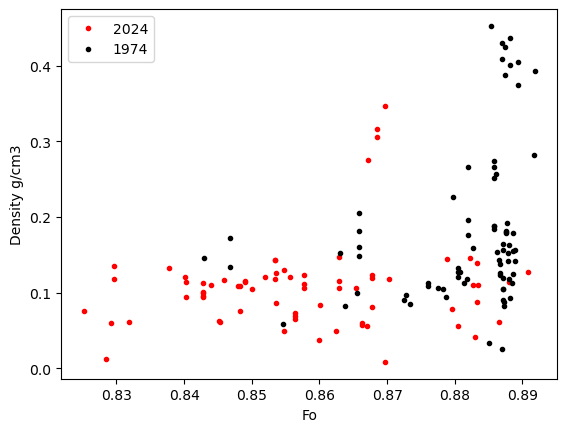

In [26]:
## Find K24 ones
K24=combined_df['filename'].str.contains('K24')
U919=combined_df['filename'].str.contains('919')
plt.plot(combined_df['Fo'].loc[K24], combined_df['Density g/cm3'].loc[K24], '.r', label='2024')
plt.plot(combined_df['Fo'].loc[U919], combined_df['Density g/cm3'].loc[U919], '.k', label='1974')
plt.legend()
plt.ylabel('Density g/cm3')
plt.xlabel('Fo')